In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from shapely.wkt import loads
from shapely.geometry import shape, Point
import urllib.request, json
import requests
import urllib.parse
import os

import warnings
warnings.filterwarnings('ignore')

/Users/lizjohnson/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_9484/3378046401.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Sh

In [2]:
camera_locs = pd.read_csv('../Data/aggregated_camera_locs.csv',index_col = 0)
camera_locs['geometry'] = camera_locs['geometry'].apply(loads)
camera_locs = gpd.GeoDataFrame(camera_locs,geometry = 'geometry', crs = '4326')
camera_locs = camera_locs.to_crs(32618)
#redefine x and y columns
camera_locs['x'] = camera_locs.geometry.x
camera_locs['y'] = camera_locs.geometry.y
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (588147.072 4505188.861),588147.071612,4.505189e+06
1,Amnesty,5,POINT (586867.513 4498122.217),586867.512967,4.498122e+06
2,Amnesty,1,POINT (587375.934 4506652.088),587375.933703,4.506652e+06
3,Amnesty,7,POINT (592666.168 4502926.211),592666.167996,4.502926e+06
4,Amnesty,1,POINT (587913.940 4503283.593),587913.939630,4.503284e+06


In [3]:
building_gdf = gpd.read_file('../Data/bk_building_block_boundary/bk_building_block_boundary.shp')
building_gdf = building_gdf.rename(columns = {'index':'Block'})
building_gdf = building_gdf.to_crs(32618)
building_gdf.head()

,Block,geometry
0,20.0,"POLYGON ((585767.652 4506366.667, 585664.224 4..."
1,30.0,"POLYGON ((585581.640 4506299.892, 585562.351 4..."
2,34.0,"POLYGON ((586140.077 4506300.563, 586104.949 4..."
3,35.0,"POLYGON ((585051.380 4506225.694, 585049.059 4..."
4,42.0,"POLYGON ((585922.424 4506215.881, 585803.337 4..."


In [4]:
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry = bk_bndry.to_crs(32618)
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((584478.960 4491458.524, 584470..."


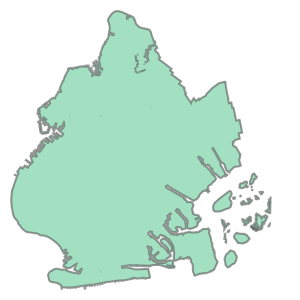

In [5]:
bk_bndry.geometry.values[0]

In [6]:
camera_locs.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
building_gdf.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
bk_bndry.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Rasterize the building geo dataframe to exclude points from camera data

In [9]:
import rasterio.features

# Define the minimum and maximum bounds of the raster
#change this to the bk boundary shapefile
min_x, min_y, max_x, max_y = bk_bndry.total_bounds
#sample every two points, roughly ever 2m
Nx = math.ceil((max_x - min_x)/2)
Ny = math.ceil((max_y - min_y)/2)
# Create an empty raster with the desired shape and CRS
raster = np.zeros((Ny,Nx), dtype=np.int16)
transform = rasterio.transform.from_bounds(min_x, min_y, max_x, max_y, Nx, Ny)

# Rasterize the buildings into the raster
buildings_mask = rasterio.features.geometry_mask(building_gdf.geometry, out_shape=raster.shape, transform=transform, invert=True)
raster[buildings_mask] = -9999

# Get the boundary polygon
boundary_polygon = bk_bndry.geometry.values[0]

# Create a mask for the pixels outside the boundary
boundary_mask = rasterio.features.geometry_mask([boundary_polygon], out_shape=raster.shape, transform=transform, invert=False)

# Set the values of the pixels outside the boundary to -9999
raster[boundary_mask] = -9999

# Set the remaining cells to -128
raster[raster == 0] = -128


In [10]:
print(Nx,Ny)

8811 9434


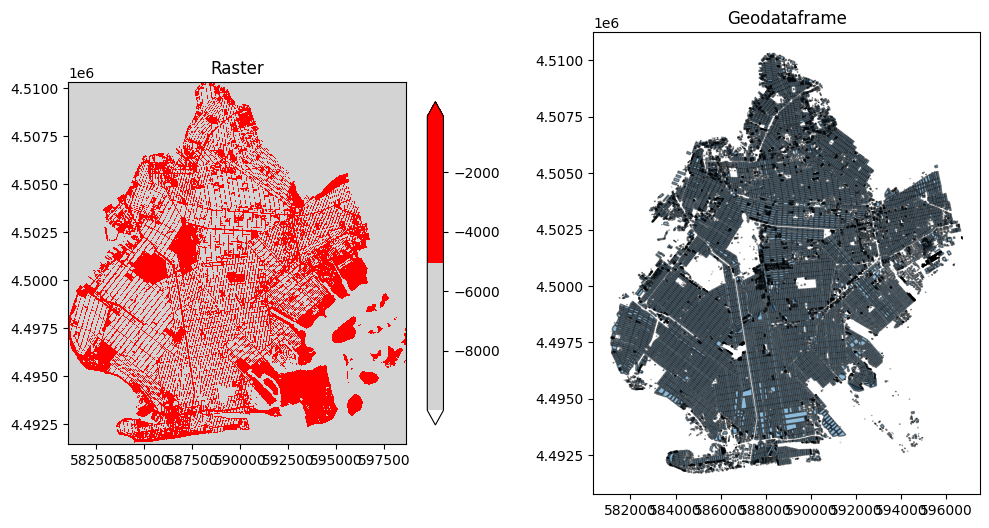

In [11]:
import matplotlib.colors as colors

# Define a color map for the raster
cmap = colors.ListedColormap(['lightgray', 'red'])
cmap.set_under(color='white')

# Plot the raster
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
raster_image = ax1.imshow(raster, cmap=cmap, vmin=-9999, vmax=-128, extent=[min_x, max_x, min_y, max_y])
ax1.set_title('Raster')

# Plot the geodataframe
building_gdf.plot(ax=ax2, alpha=0.5, edgecolor='k')
ax2.set_title('Geodataframe')

# Add a colorbar
fig.colorbar(raster_image, ax=ax1, extend='both', shrink=0.7)

# Show the plot
plt.show()

In [12]:
land_reference = raster
print(land_reference.shape)
#flattens the raster into 1 dimensional array
land_mask = (land_reference > -9999).ravel()
print(land_mask.shape)
x_grid, y_grid = np.meshgrid(np.linspace(min_x, max_x,Nx),
                             np.linspace(min_y, max_y, Ny))
y_grid = y_grid[::-1]
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
print(grid_points.shape)
grid_points = grid_points[land_mask]
print(grid_points.shape)

(9434, 8811)
(83122974,)
(83122974, 2)
(24530015, 2)


In [13]:
grid_points

array([[ 588251.06433635, 4510323.97481727],
       [ 588253.06450765, 4510323.97481727],
       [ 588255.06467896, 4510323.97481727],
       ...,
       [ 584470.74056799, 4491457.25447094],
       [ 584472.74073929, 4491457.25447094],
       [ 584474.7409106 , 4491457.25447094]])

In [14]:
# Count occurrences of True and False
true_count = np.count_nonzero(land_mask)
false_count = land_mask.size - true_count

print("True count:", true_count)
print("False count:", false_count)

True count: 24530015
False count: 58592959


In [15]:
#standardize the camera count metric to use as our target variable
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

data = np.asarray(camera_locs['Camera_Count']).reshape(-1, 1)
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(data)
y_data = scaler.transform(data)

X_data = np.vstack([camera_locs['x'],camera_locs['y']]).T
# y = np.array(camera_locs["Data_Source"] == "Amnesty", dtype=int)

In [16]:
y_data[:10]

array([[0.25  ],
       [0.25  ],
       [0.    ],
       [0.375 ],
       [0.    ],
       [0.125 ],
       [0.0625],
       [0.    ],
       [0.1875],
       [0.    ]])

In [17]:
X_data[:10]

array([[ 588147.07161245, 4505188.86062826],
       [ 586867.51296664, 4498122.21674541],
       [ 587375.93370312, 4506652.08754618],
       [ 592666.16799647, 4502926.21110367],
       [ 587913.93963028, 4503283.59252384],
       [ 587841.31876905, 4495391.16488008],
       [ 588340.31358102, 4507900.0470682 ],
       [ 589735.68823608, 4492479.78569519],
       [ 591343.2992308 , 4502219.92109406],
       [ 586154.4109412 , 4499844.40780503]])

### Let's fit the KDE with the y variables now and increase our sampling size

In [18]:
kde = KernelDensity(bandwidth = 200, metric="euclidean", kernel='gaussian')
kde.fit(X_data,y_data)

KernelDensity(bandwidth=200)

In [19]:
grid_points.shape

(24530015, 2)

In [20]:
# evaluate only on the land: 0 indicates ocean or building
Z = np.full(land_mask.shape[0], 0.0)
Z[land_mask] = np.exp(kde.score_samples(grid_points))
Z = Z.reshape(x_grid.shape)

In [21]:
print(Z.min(),Z.max())

0.0 6.818664541637566e-08


In [22]:
levels = np.linspace(0, Z.max(), 25)
levels

array([0.00000000e+00, 2.84111023e-09, 5.68222045e-09, 8.52333068e-09,
       1.13644409e-08, 1.42055511e-08, 1.70466614e-08, 1.98877716e-08,
       2.27288818e-08, 2.55699920e-08, 2.84111023e-08, 3.12522125e-08,
       3.40933227e-08, 3.69344329e-08, 3.97755432e-08, 4.26166534e-08,
       4.54577636e-08, 4.82988738e-08, 5.11399841e-08, 5.39810943e-08,
       5.68222045e-08, 5.96633147e-08, 6.25044250e-08, 6.53455352e-08,
       6.81866454e-08])

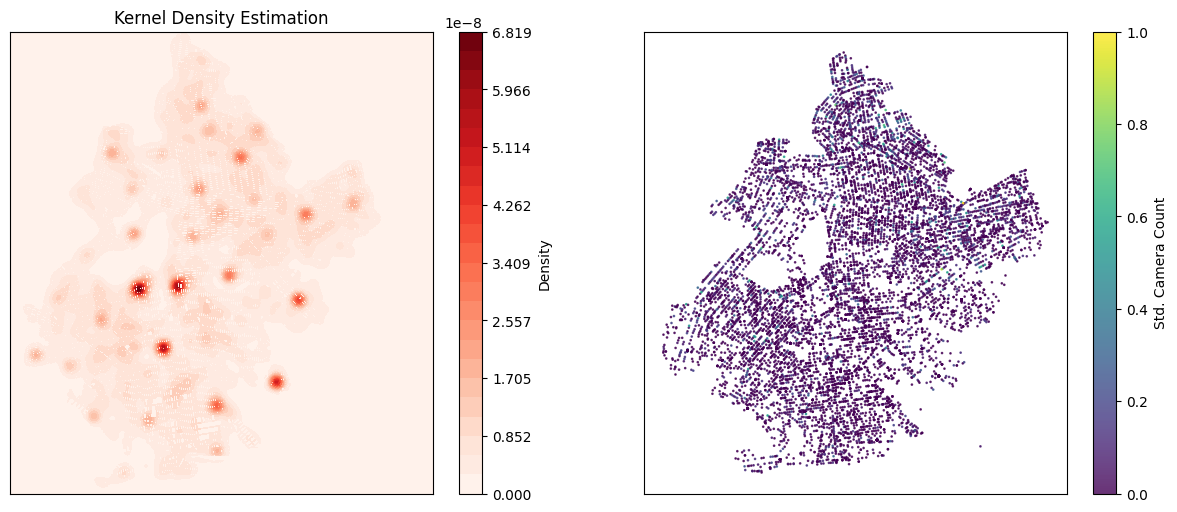

In [23]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
contour = ax[0].contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

# Set title
ax[0].set_title('Kernel Density Estimation')

# Plot data as points
scatter = ax[1].scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap='viridis', s = 0.8, alpha = 0.8)

# Add a colorbar for both plots
cbar = plt.colorbar(contour, ax=ax[0])
cbar.set_label('Density')
cbar = plt.colorbar(scatter, ax=ax[1])
cbar.set_label('Std. Camera Count')

# Turn off axes labels
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

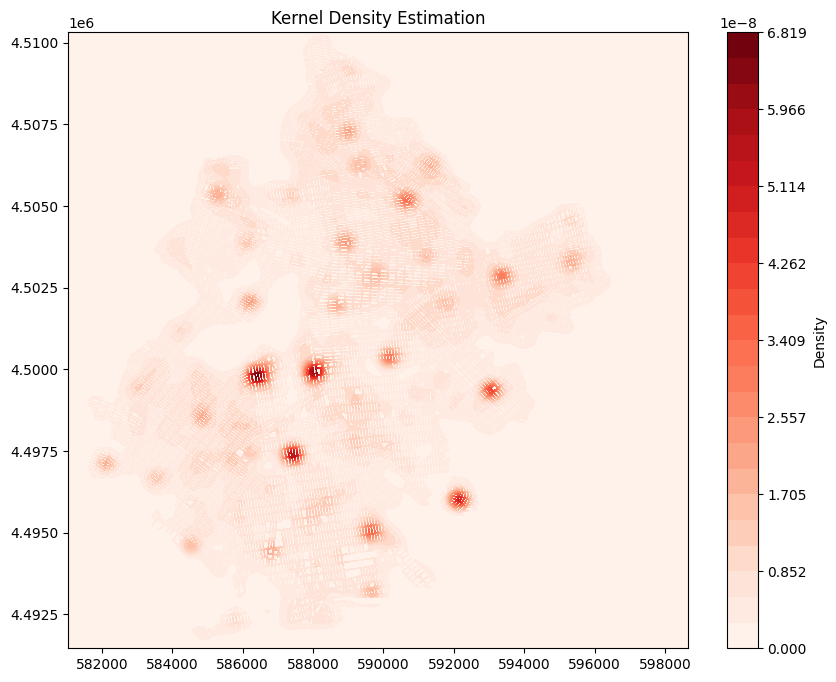

In [24]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

# Set title
ax.set_title('Kernel Density Estimation')
# Add a colorbar for both plots
cbar = plt.colorbar(contour)
cbar.set_label('Density')
# cbar = plt.colorbar(scatter, ax=ax[1])
# cbar.set_label('Std. Camera Count')

# Turn off axes labels
# ax.set_xticks([])
# ax.set_yticks([])

plt.savefig('../Outputs/KDE_Output_Heatmap.png', bbox_inches = 'tight')
plt.show()

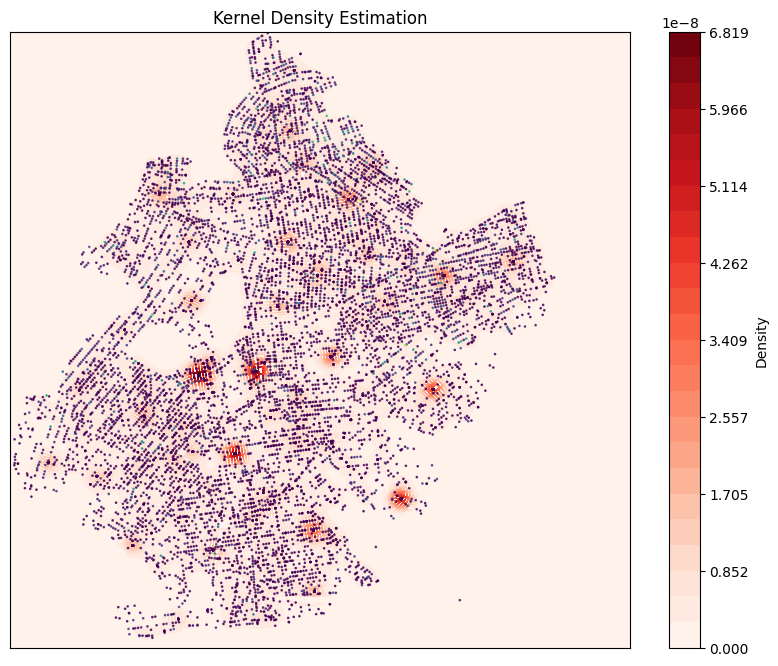

In [25]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(x_grid, y_grid, Z, levels=levels, cmap=plt.cm.Reds)

# Set title
ax.set_title('Kernel Density Estimation')

# Plot data as points
scatter = ax.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap='viridis', s = 0.8, alpha = 0.8)

# Add a colorbar for both plots
cbar = plt.colorbar(contour)
cbar.set_label('Density')
# cbar = plt.colorbar(scatter, ax=ax[1])
# cbar.set_label('Std. Camera Count')

# Turn off axes labels
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../Outputs/KDE_Output_Heatmap_camera_locs.png', bbox_inches = 'tight')
plt.show()

In [26]:
import pickle
# Save the array as a pickle file
with open('../Outputs/KDE_output_200m.pickle','wb') as f:
    pickle.dump(Z, f)